In [7]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/
Mounted at /content/gdrive
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'   Passwords.kdbx
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'


In [8]:
!cp /mydrive/data_for_train/persons/joe_biden.jpg ./

In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite

--2021-07-24 02:39:54--  https://storage.googleapis.com/download.tensorflow.org/models/tflite/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13269068 (13M) [application/octet-stream]
Saving to: ‘posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite’

posenet_mobilenet_v 100%[===================>]  12.65M  --.-KB/s    in 0.1s    

2021-07-24 02:39:54 (131 MB/s) - ‘posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite’ saved [13269068/13269068]



In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
import math

In [9]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
template_path = "joe_biden.jpg"
target_path = "joe_biden_sit.jpeg"

In [5]:
# Load TFLite model and allocate tensors (memory usage method reducing latency)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [6]:
# Get input and output tensors information from the model file
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

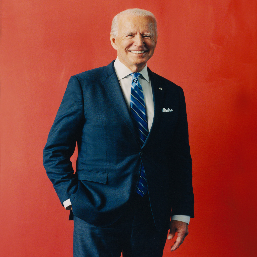

In [11]:
template_image_src = cv.imread(template_path)
# src_tepml_width, src_templ_height, _ = template_image_src.shape 
template_image = cv.resize(template_image_src, (width, height))
cv2_imshow(template_image)

In [13]:
template_input = np.expand_dims(template_image.copy(), axis=0)

In [14]:
floating_model = input_details[0]['dtype'] == np.float32

In [15]:
if floating_model:
  template_input = (np.float32(template_input) - 127.5) / 127.5

In [16]:
# Process template image
# Sets the value of the input tensor
interpreter.set_tensor(input_details[0]['index'], template_input)
# Runs the computation
interpreter.invoke()
# Extract output data from the interpreter
template_output_data = interpreter.get_tensor(output_details[0]['index'])
template_offset_data = interpreter.get_tensor(output_details[1]['index'])
# Getting rid of the extra dimension
template_heatmaps = np.squeeze(template_output_data)
template_offsets = np.squeeze(template_offset_data)
print("template_heatmaps' shape:", template_heatmaps.shape)
print("template_offsets' shape:", template_offsets.shape)

template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)


In [17]:
def parse_output(heatmap_data,offset_data, threshold):

  '''
  Input:
    heatmap_data - hetmaps for an image. Three dimension array
    offset_data - offset vectors for an image. Three dimension array
    threshold - probability threshold for the keypoints. Scalar value
  Output:
    array with coordinates of the keypoints and flags for those that have
    low probability
  '''

  joint_num = heatmap_data.shape[-1]
  pose_kps = np.zeros((joint_num,3), np.uint32)

  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
      max_prob = np.max(joint_heatmap)

      if max_prob > threshold:
        if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
          pose_kps[i,2] = 1

  return pose_kps

In [18]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
      if kps[i,2]:
        if isinstance(ratio, tuple):
          cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
          continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),-1)
    return show_img

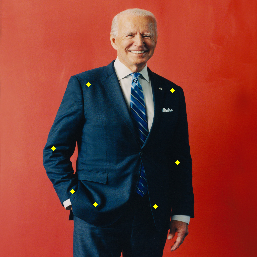

In [19]:
template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
template_show = np.array(template_show*255,np.uint8)
template_kps = parse_output(template_heatmaps,template_offsets,0.3)
cv2_imshow(draw_kps(template_show.copy(),template_kps))

In [20]:
parts_to_compare = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]

In [21]:
def angle_length(p1, p2):

  '''
  Input:
    p1 - coordinates of point 1. List
    p2 - coordinates of point 2. List
  Output:
    Tuple containing the angle value between the line formed by two input points 
    and the x-axis as the first element and the length of this line as the second
    element
  '''

  angle = math.atan2(- int(p2[0]) + int(p1[0]), int(p2[1]) - int(p1[1])) * 180.0 / np.pi
  length = math.hypot(int(p2[1]) - int(p1[1]), - int(p2[0]) + int(p1[0]))
  
  return round(angle), round(length)

In [22]:
template_values = []
for part in parts_to_compare:
  template_values.append(angle_length(template_kps[part[0]][:2], template_kps[part[1]][:2]))
template_values

[(176, 84),
 (-86, 72),
 (-119, 73),
 (-86, 51),
 (-66, 47),
 (178, 60),
 (-98, 117),
 (-87, 120),
 (-102, 62),
 (-90, 69),
 (28, 19),
 (92, 75)]

In [23]:
def matching(template_kp, target_kp, angle_deviation=30, size_deviation=1):

  '''Input:
      1. template_kp - list of tuples (for the template image) containng angles 
      between particular body parts and x-axis as first elements and its sizes 
      (distances between corresponding points as second elements)
      2. target_kp - same for the target image
      3. angle_deviation - acceptable angle difference between corresponding 
      body parts in the images
      4. size_deviation - acceptable proportions difference between the images
    Output:
      List of body parts which are deviated
  '''

  devs = []

  # set an anchor size for proportions calculations - distance between shoulders
  templ_anchor = template_kp[0][1]
  targ_anchor = target_kp[0][1]

  # for each body part that we calculated angle and size for
  for i in range(len(template_kp)):

    angles = (template_kp[i][0], target_kp[i][0])
    diff_angle = max(angles) - min(angles)

    templ_size = (template_kp[i][1],templ_anchor)
    templ_size = abs(min(templ_size) / max(templ_size))

    tar_size = (target_kp[i][1], targ_anchor)
    tar_size = abs(min(tar_size) / max(tar_size))

    if diff_angle > angle_deviation:
      devs.append(i)
      print("{0} has different angle".format(i))

    elif max(tar_size,templ_size) - min(tar_size,templ_size) > size_deviation:
      devs.append(i)
      print("{0} has different size".format(i))

  return devs

In [24]:
# Get a zero matrix with the shape of the template image
template_pose = np.zeros_like(template_show)

In [25]:
# connect some of the points 
def join_point(img, kps):

  body_parts = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),
                      (6,12),(11,13),(12,14),(13,15),(14,16)]

  for part in body_parts:
    cv.line(img, (kps[part[0]][1], kps[part[0]][0]), (kps[part[1]][1], kps[part[1]][0]), 
            color=(255,255,255), lineType=cv.LINE_AA, thickness=3)

In [26]:
# draw a skeleton of the template pose to the empty image
join_point(template_pose, template_kps[:, :2])

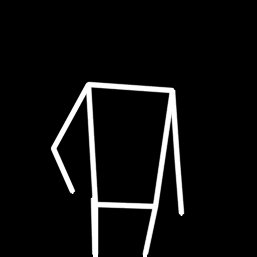

In [27]:
cv2_imshow(template_pose)

In [28]:
# set the new dimensions of the image to reduce the size
buffer = 5 # size of the area around the pose
top_left_y = min(template_kps[5:, 0]) - buffer
top_left_x = min(template_kps[5:, 1]) - buffer
buttom_right_y = max(template_kps[5:, 0]) + buffer
buttom_right_x = max(template_kps[5:, 1]) + buffer

In [29]:
# crop the template pose with new dimensions
template_pose = template_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

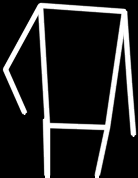

In [30]:
cv2_imshow(template_pose)